   # Machine Learning Model


    * Getting data from the database
    * Feature engineering
        . Data analysis
    * Feature selection
        . Check for skewness
        . Remove unncessary columns/rows
        . Feature selection
        . Address the skew by cuberrot transformer on positively skewd values
        .Address the skew by cuberrot transformer on negetively skewed values
        . Remove null values
    * Data was split into train and test
    * Model choice
    * Hyperparameter tuning
    

In [1]:
# Import dependencies
import pandas as pd
import wbgapi as wb
import numpy as np


from sqlalchemy import create_engine
import psycopg2
from config import db_password

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing

from sklearn.metrics import balanced_accuracy_score

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import ConfusionMatrixDisplay


import warnings

warnings.filterwarnings('ignore')

# Hypothesis

--Hypothesis to be tested: CO2 emissions depend on features available in the dataset such as energy use, population metrics, GDP, cereal yield, etc. and can be predicted from these.

--Co2 emissions in the dataset are treated as dependent variables.

# Fetch data from AWS

In [2]:
user = "postgres"
password = db_password
host = "emissions-db.cr5mfnfivfxl.us-east-1.rds.amazonaws.com"
port = '5432'
database = "GHG_emissions"
conn_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'
        
        # Create an instance of database engine
engine = create_engine(conn_string)
# Raw SQL to send to database
sql_emissions_list = """ SELECT   emissions_per_capita,  
    pop_0014_percent, pop_1564_percent, pop_65up_percent, pop_growth_percent, pop_total,
    urban_pop_total, urban_pop_percent, fossil_energy_use, electricity_access_percent,
    cereal_yield, gdp_per_capita
    FROM ghg_emissions;"""
        # Read the database results into Pandas dataframe
emissions_df = pd.read_sql(sql_emissions_list,engine );
emissions_df

,emissions_per_capita,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,pop_total,urban_pop_total,urban_pop_percent,fossil_energy_use,electricity_access_percent,cereal_yield,gdp_per_capita
0,0.762487,42.517883,54.314703,3.167414,2.081806,14452704.0,4667645.0,32.296000,NaN,42.561729,435.100000,1421.787789
1,0.878139,42.872671,54.029704,3.097626,2.136294,14154937.0,4584076.0,32.385000,NaN,33.700001,557.500000,1410.329174
2,0.871840,43.172363,53.799451,3.028186,2.191391,13855753.0,4503674.0,32.504000,NaN,32.299999,831.400000,1407.034293
3,0.905911,43.370440,53.634994,2.994566,2.163267,13555422.0,4426387.0,32.654000,29.095759,40.498375,668.500000,1408.367810
4,0.905368,43.453948,53.556956,2.989096,1.822309,13265331.0,4355539.0,32.834000,28.860873,44.000000,695.700000,1290.193956
...,...,...,...,...,...,...,...,...,...,...,...,...
7177,0.906340,45.568530,51.544417,2.887053,2.619955,344418362.0,92816300.0,26.948709,48.811618,NaN,1374.695849,697.183018
7178,0.904581,45.643524,51.460703,2.895773,2.658526,335625136.0,88973631.0,26.509823,49.280685,NaN,1427.680683,704.742868
7179,0.902599,45.607528,51.492668,2.899804,2.633682,326933522.0,85244233.0,26.073874,47.966507,NaN,949.672903,728.765774
7180,0.937815,45.580850,51.518647,2.900503,2.792410,318544083.0,81691094.0,25.645146,50.493553,NaN,1364.936487,858.297836


In [3]:
#fetch data set from Database
emissions_df.shape

(7182, 12)

In [4]:
GHG_df = emissions_df
GHG_df.shape

(7182, 12)

#  Data Preprocessing

### Check Skew

In [5]:
#check skewness 
GHG_df.skew(axis = 0, skipna = True).sort_values(ascending=False)

urban_pop_total               5.266107
pop_total                     5.054372
cereal_yield                  4.327581
gdp_per_capita                3.680850
emissions_per_capita          2.740454
pop_65up_percent              1.130057
urban_pop_percent             0.122207
pop_0014_percent             -0.010011
pop_1564_percent             -0.126337
pop_growth_percent           -0.266227
fossil_energy_use            -0.787508
electricity_access_percent   -1.278649
dtype: float64

In [6]:
#skewness reduction using cuberoot transformation for positively skewed values 
#and adding the newly skewed columns to dataframe

GHG_df['urban_pop_total_cbrt'] = np.cbrt(GHG_df['urban_pop_total'])
GHG_df['pop_total_cbrt'] = np.cbrt(GHG_df['pop_total'])
GHG_df['cereal_yield_cbrt'] = np.cbrt(GHG_df['cereal_yield'])
GHG_df['gdp_per_capita_cbrt'] = np.cbrt(GHG_df['gdp_per_capita'])
GHG_df['emissions_per_capita_cbrt'] = np.cbrt(GHG_df['emissions_per_capita'])


In [7]:
#skewness reduction using cube transformation for negitively skewed values 
#and adding the newly skewed columns to dataframe

GHG_df['electricity_access_percent_cube'] = np.power(GHG_df['electricity_access_percent'],3)

In [8]:
#check dtypes of Data Frame
GHG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   emissions_per_capita             6430 non-null   float64
 1   pop_0014_percent                 7155 non-null   float64
 2   pop_1564_percent                 7155 non-null   float64
 3   pop_65up_percent                 7155 non-null   float64
 4   pop_growth_percent               7153 non-null   float64
 5   pop_total                        7155 non-null   float64
 6   urban_pop_total                  7101 non-null   float64
 7   urban_pop_percent                7101 non-null   float64
 8   fossil_energy_use                4723 non-null   float64
 9   electricity_access_percent       6041 non-null   float64
 10  cereal_yield                     5948 non-null   float64
 11  gdp_per_capita                   6687 non-null   float64
 12  urban_pop_total_cbrt

In [9]:
#check skewness on raw data
GHG_df.skew(axis = 0, skipna = True).sort_values(ascending=False)

urban_pop_total                    5.266107
pop_total                          5.054372
cereal_yield                       4.327581
gdp_per_capita                     3.680850
emissions_per_capita               2.740454
pop_total_cbrt                     1.989828
urban_pop_total_cbrt               1.931646
pop_65up_percent                   1.130057
gdp_per_capita_cbrt                1.009301
cereal_yield_cbrt                  0.596332
emissions_per_capita_cbrt          0.362554
urban_pop_percent                  0.122207
pop_0014_percent                  -0.010011
pop_1564_percent                  -0.126337
pop_growth_percent                -0.266227
electricity_access_percent_cube   -0.768246
fossil_energy_use                 -0.787508
electricity_access_percent        -1.278649
dtype: float64

In [10]:
#columns to be droped from data frame after reducing and adding newly skewed columns

drop_columns = ['urban_pop_total',
'pop_total',
'cereal_yield',           
'gdp_per_capita',                                       
'emissions_per_capita',                 
'electricity_access_percent']

In [11]:
#drop the unskewed columns
GHG_df.drop(columns = drop_columns, axis = 1, inplace = True)

In [12]:
#check for the skewness after reducing
GHG_df.skew().sort_values(ascending=False)

pop_total_cbrt                     1.989828
urban_pop_total_cbrt               1.931646
pop_65up_percent                   1.130057
gdp_per_capita_cbrt                1.009301
cereal_yield_cbrt                  0.596332
emissions_per_capita_cbrt          0.362554
urban_pop_percent                  0.122207
pop_0014_percent                  -0.010011
pop_1564_percent                  -0.126337
pop_growth_percent                -0.266227
electricity_access_percent_cube   -0.768246
fossil_energy_use                 -0.787508
dtype: float64

In [13]:
#Check  for null values
GHG_df.describe()

,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,urban_pop_percent,fossil_energy_use,urban_pop_total_cbrt,pop_total_cbrt,cereal_yield_cbrt,gdp_per_capita_cbrt,emissions_per_capita_cbrt,electricity_access_percent_cube
count,7155.000000,7155.000000,7155.000000,7153.000000,7101.000000,4723.000000,7101.000000,7155.000000,5948.000000,6687.000000,6430.000000,6041.000000
mean,31.129357,61.741906,7.128736,1.489059,55.109050,65.910120,262.598398,332.932388,13.482311,17.451932,1.363663,683667.081873
std,10.559871,6.947037,4.953521,1.662774,23.541963,29.004060,276.876940,358.209003,3.142651,9.552493,0.623288,395137.834194
min,11.599104,46.097007,0.171770,-27.722225,5.416000,0.000000,15.512650,20.940117,3.249112,2.837687,0.000000,0.152187
25%,21.243883,55.403983,3.302148,0.554488,35.175000,45.438606,86.304939,109.769047,11.180543,9.933725,0.858121,281957.276538
50%,30.983912,63.224729,5.106476,1.420004,53.979000,75.875796,158.869003,203.422941,13.336183,14.732028,1.339606,948136.136608
75%,41.144452,67.099729,10.479762,2.424812,74.127000,88.652917,316.339781,381.376717,15.550753,23.396792,1.839912,1000000.000000
max,51.180881,86.079246,35.041340,19.360429,100.000000,100.000000,1596.134541,1956.731860,33.250587,58.797054,3.625420,1000000.000000


## Checking for null values


In [14]:
#check for null values
GHG_df.isna().sum()

pop_0014_percent                     27
pop_1564_percent                     27
pop_65up_percent                     27
pop_growth_percent                   29
urban_pop_percent                    81
fossil_energy_use                  2459
urban_pop_total_cbrt                 81
pop_total_cbrt                       27
cereal_yield_cbrt                  1234
gdp_per_capita_cbrt                 495
emissions_per_capita_cbrt           752
electricity_access_percent_cube    1141
dtype: int64

In [15]:
#drop null values
GHG_df.dropna(inplace=True)

In [16]:
#check for null values
GHG_df.isna().sum()

pop_0014_percent                   0
pop_1564_percent                   0
pop_65up_percent                   0
pop_growth_percent                 0
urban_pop_percent                  0
fossil_energy_use                  0
urban_pop_total_cbrt               0
pop_total_cbrt                     0
cereal_yield_cbrt                  0
gdp_per_capita_cbrt                0
emissions_per_capita_cbrt          0
electricity_access_percent_cube    0
dtype: int64

In [17]:
#check for the shape of the dataframe
GHG_df.shape

(3742, 12)

In [18]:
#renaming the new column headers after cube and cuberoot transformantion
column_names = {
    'urban_pop_total_cbrt':'total_urban_pop',
    'pop_total_cbrt':'total_pop',
    'cereal_yield_cbrt':'cereal_yld',
    'gdp_per_capita_cbrt':'gdp_pr_capita',
    'emissions_per_capita_cbrt':'emissions_pr_capita',
    'electricity_access_percent_cube':'electricity_access_percentage',
}

In [19]:
# Rename the columns headers
GHG_df = GHG_df.rename(columns=column_names)
GHG_df.sample(5)

,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,urban_pop_percent,fossil_energy_use,total_urban_pop,total_pop,cereal_yld,gdp_pr_capita,emissions_pr_capita,electricity_access_percentage
5656,26.453503,63.329161,10.217335,1.006297,90.366,89.225378,330.298004,341.641746,16.253766,19.319255,1.598292,920962.647663
1609,16.116757,67.133473,16.749770,0.547668,55.666,85.256733,179.672160,218.415831,14.290854,23.475116,1.846505,1000000.000000
4338,31.952884,62.638917,5.408199,1.263376,70.020,86.898275,187.420589,211.061938,16.346729,16.722216,1.299441,909186.975288
5333,38.388666,57.718504,3.892830,3.033102,45.330,0.000000,49.779832,64.802398,13.324571,17.219813,1.173707,565219.058619
5541,14.377291,67.442682,18.180027,0.589387,57.336,66.253804,169.409613,203.921146,18.015213,37.019013,1.979261,1000000.000000


# Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'pop_0014_percent'}>,
        <AxesSubplot:title={'center':'pop_1564_percent'}>,
        <AxesSubplot:title={'center':'pop_65up_percent'}>],
       [<AxesSubplot:title={'center':'pop_growth_percent'}>,
        <AxesSubplot:title={'center':'urban_pop_percent'}>,
        <AxesSubplot:title={'center':'fossil_energy_use'}>],
       [<AxesSubplot:title={'center':'total_urban_pop'}>,
        <AxesSubplot:title={'center':'total_pop'}>,
        <AxesSubplot:title={'center':'cereal_yld'}>],
       [<AxesSubplot:title={'center':'gdp_pr_capita'}>,
        <AxesSubplot:title={'center':'emissions_pr_capita'}>,
        <AxesSubplot:title={'center':'electricity_access_percentage'}>]],
      dtype=object)

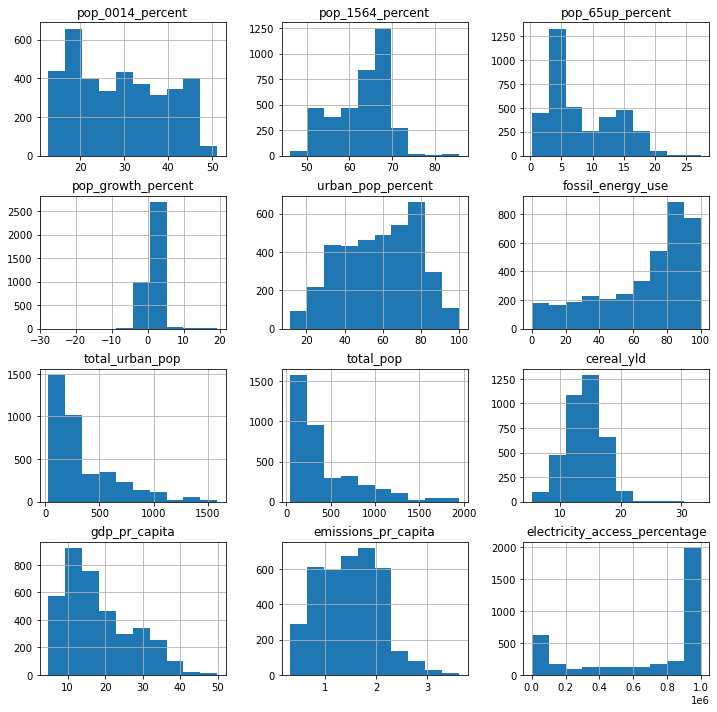

In [20]:
#plot skew on histogram
GHG_df.hist(figsize=(12, 12))

# Correlation Plot

In [21]:
# Function to plot correlation matrix
# Input parameters: dataframe
# Output: correlation dataframe
def plot_corr(df):
    corr = df.corr().abs()
    #corr = df.corr(method='pearson')
    sns.set(font_scale=2)
    f,ax=plt.subplots(figsize=(30,20))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt = ".2f", center=0, vmin=-1, vmax=1)
    plt.title('Correlation between features', fontsize=25, weight='bold' )
    plt.show()
    sns.set(font_scale=1)
    return corr
    

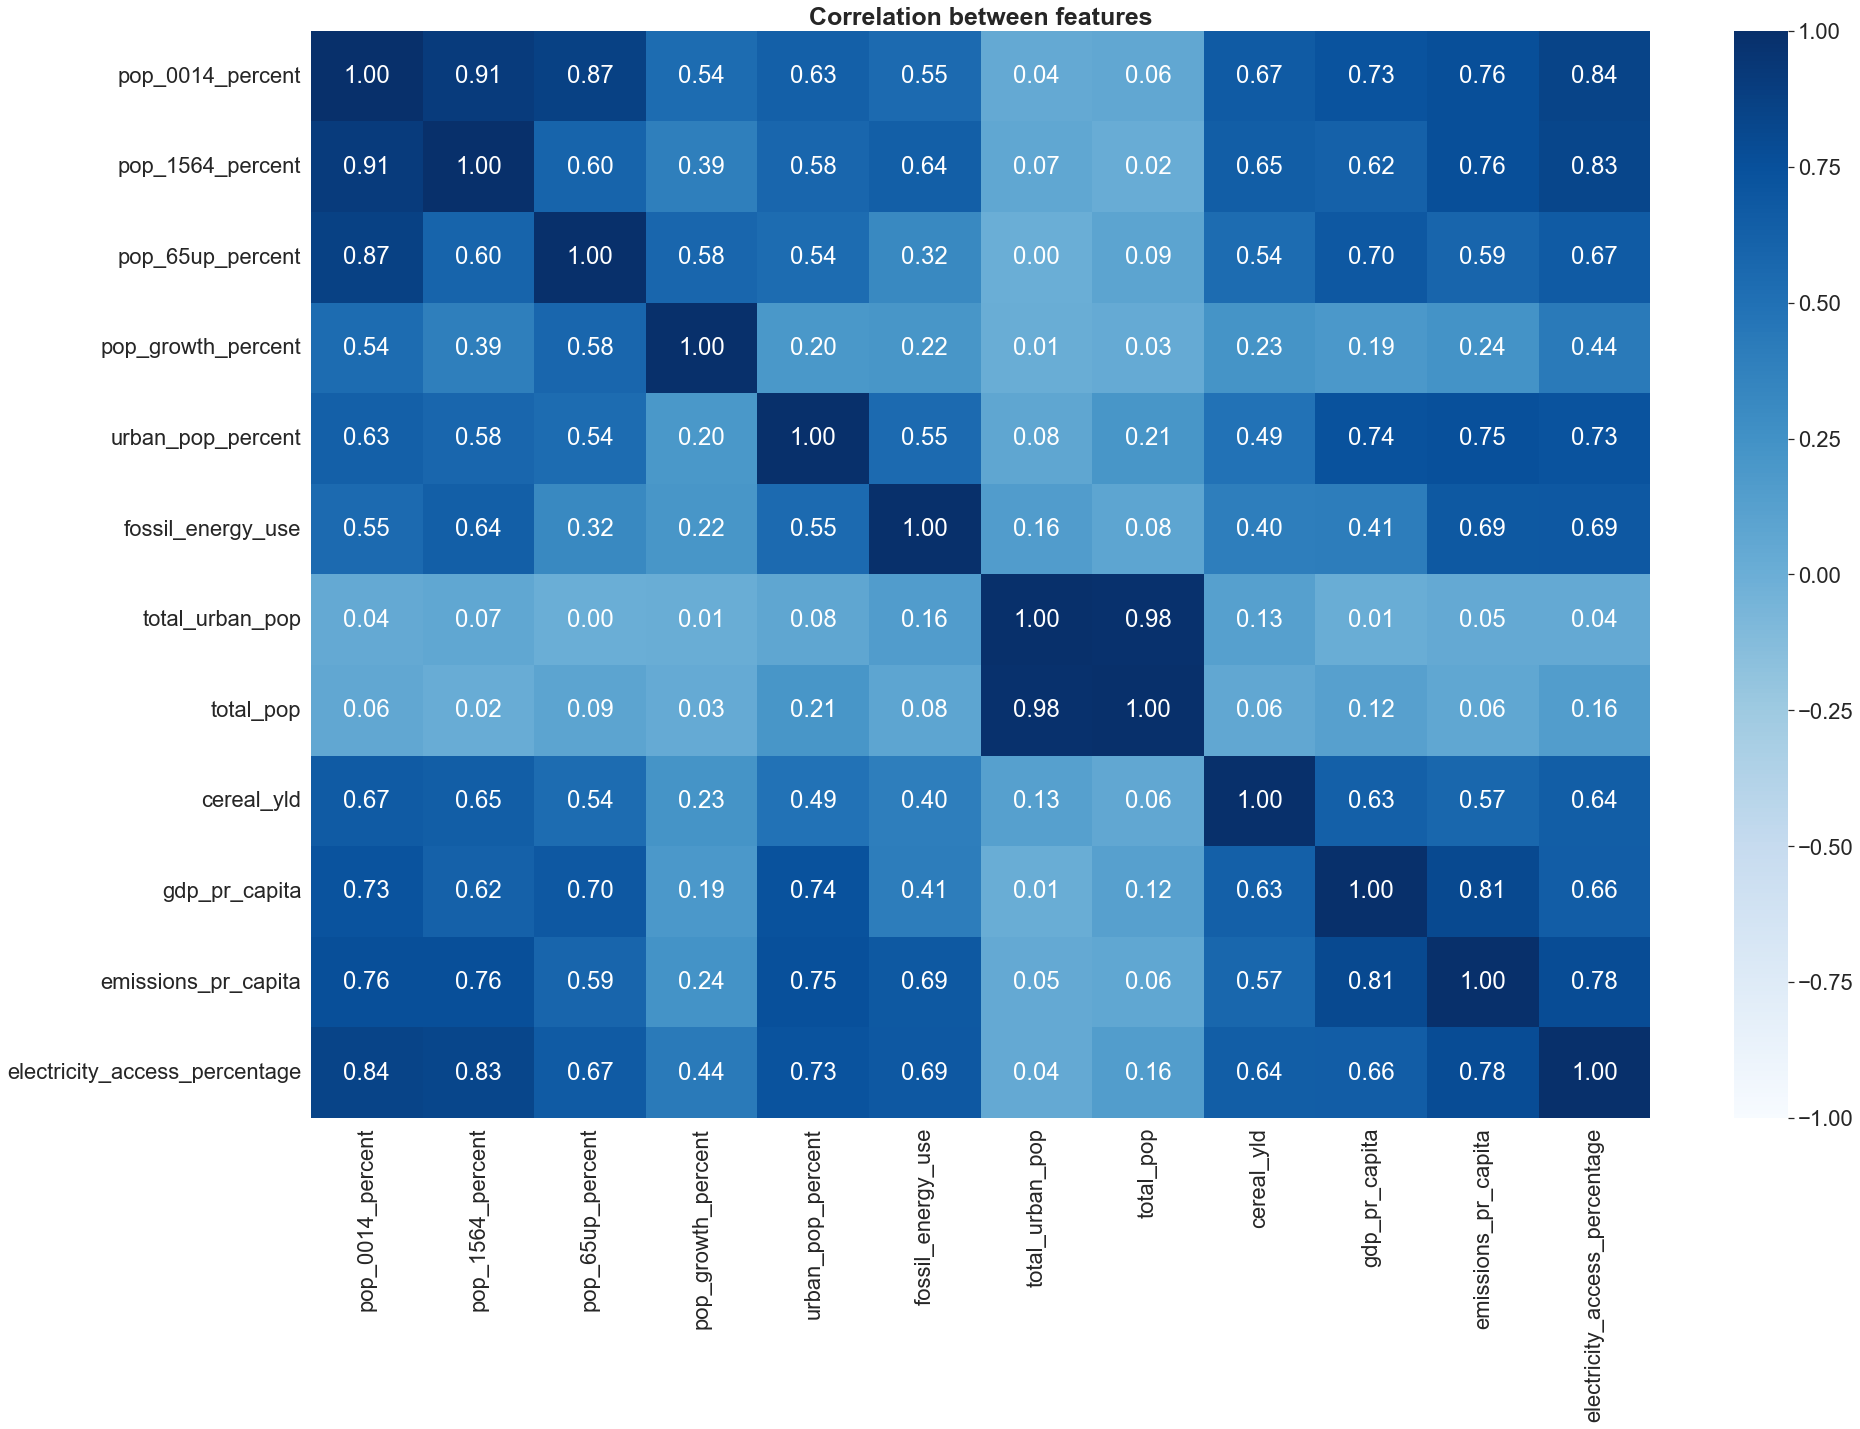

Top 10 correlations for emissions_pr_capita:
emissions_pr_capita              1.000000
gdp_pr_capita                    0.805111
electricity_access_percentage    0.781697
pop_0014_percent                 0.763771
pop_1564_percent                 0.763699
urban_pop_percent                0.751660
fossil_energy_use                0.685914
pop_65up_percent                 0.587781
cereal_yld                       0.574311
pop_growth_percent               0.236526
Name: emissions_pr_capita, dtype: float64
Bottom 5 correlations for emissions_pr_capita:
pop_65up_percent      0.587781
cereal_yld            0.574311
pop_growth_percent    0.236526
total_pop             0.063164
total_urban_pop       0.045587
Name: emissions_pr_capita, dtype: float64


In [22]:
# Plot correlation 
Initial_Correlation = plot_corr(GHG_df)
print("Top 10 correlations for emissions_pr_capita:")
print(Initial_Correlation['emissions_pr_capita'].sort_values(ascending=False)[:10]) #top 10 correlations
print("Bottom 5 correlations for emissions_pr_capita:")
print(Initial_Correlation['emissions_pr_capita'].sort_values(ascending=False)[-5:]) #least 5 correlations



.Dependent Variables:

        
        .emissions_per_capita
        
        
.Independent Variables:

        .cereal_yield
        .electricity_access_percent
        .gdp_per_capita
        .pop_growth_percent
        .pop_total
        .urban_pop_total
        .urban_pop_percent
        .pop_0014_percent
        .pop_1564_percent
        .pop_65up_percent
        .fossil_energy_use
        
   .Choosing features that have good correlation with emissions_per_capita_cbrt (correlation coefficient > 0.5)

# Feature Selection

In [23]:
#select features for analysis.
selected_features = [  'emissions_pr_capita',
                             'total_urban_pop',
                             'fossil_energy_use',
                             'pop_1564_percent',
                             'pop_growth_percent',
                            'cereal_yld',           
                            'gdp_pr_capita',               
                             'urban_pop_percent',
                     'electricity_access_percentage',
                     'pop_0014_percent' 
                           ]
ftr_df = pd.DataFrame(GHG_df, columns = selected_features)


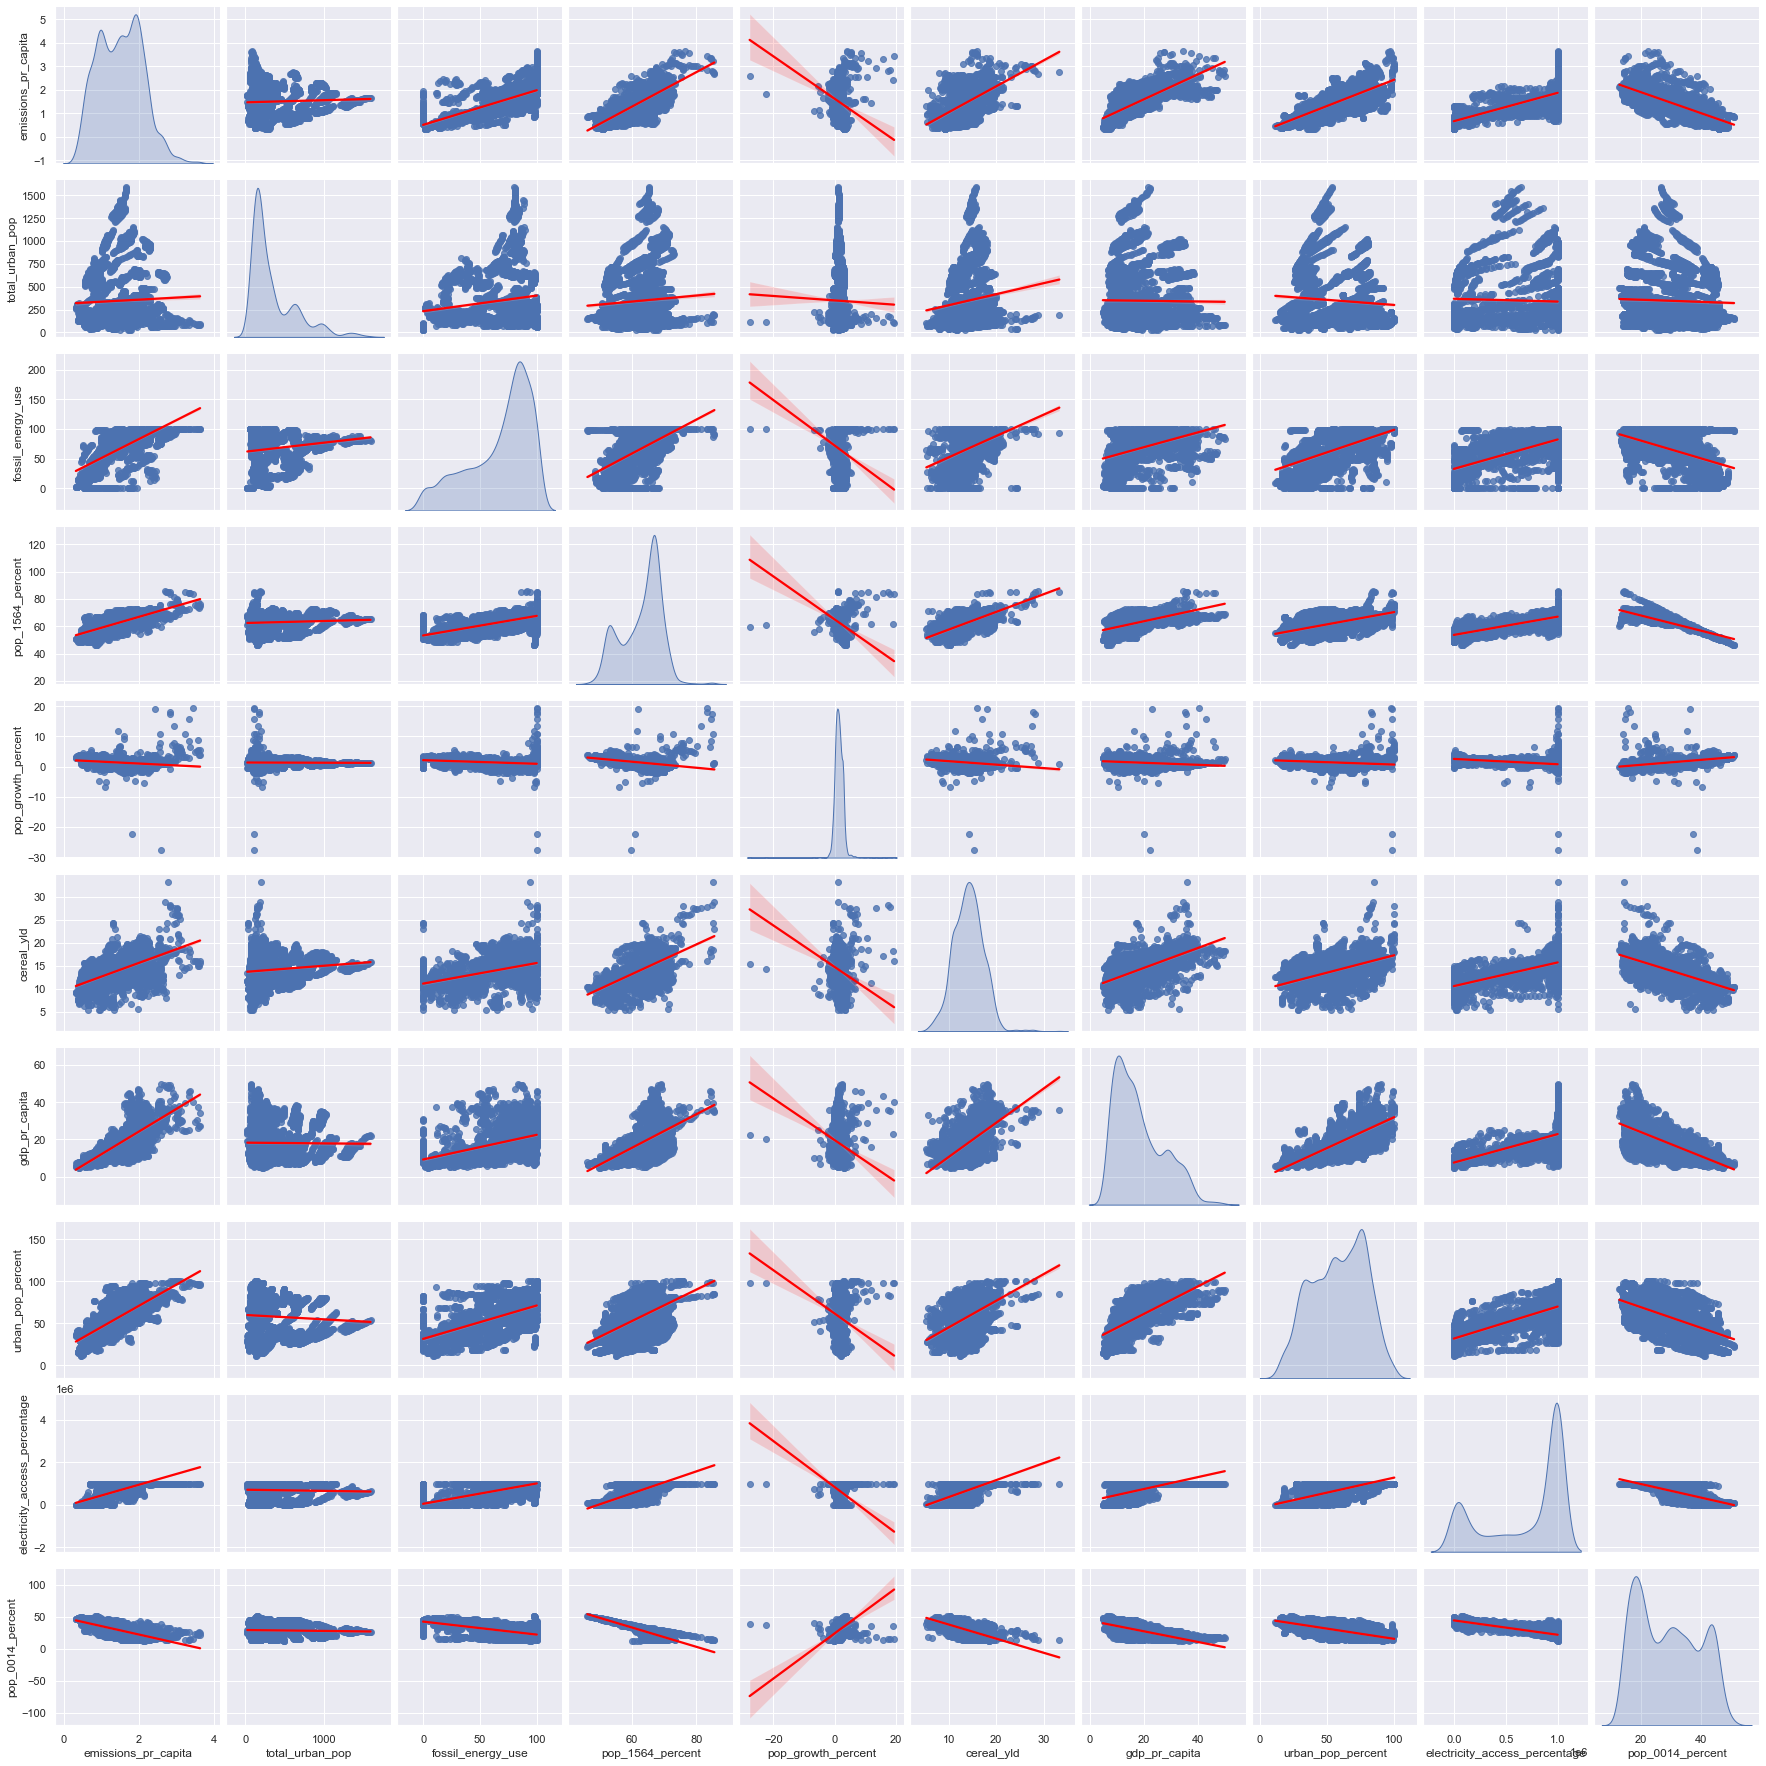

In [24]:
#pair ploting 
sns.pairplot(ftr_df, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})

In [25]:
#check data shape after droping null values
ftr_df.shape

(3742, 10)

In [26]:
#check skew after droping null values
ftr_df.skew().sort_values(ascending=False)

total_urban_pop                  1.590182
gdp_pr_capita                    0.792386
cereal_yld                       0.264723
emissions_pr_capita              0.233065
pop_0014_percent                 0.219062
urban_pop_percent               -0.177360
pop_1564_percent                -0.410598
pop_growth_percent              -0.464445
electricity_access_percentage   -0.796884
fossil_energy_use               -0.861197
dtype: float64

In [27]:
ftr_df.head()

,emissions_pr_capita,total_urban_pop,fossil_energy_use,pop_1564_percent,pop_growth_percent,cereal_yld,gdp_pr_capita,urban_pop_percent,electricity_access_percentage,pop_0014_percent
3,0.967598,164.191169,29.095759,53.634994,2.163267,8.743805,11.209133,32.654,66422.128802,43.370440
4,0.967405,163.310448,28.860873,53.556956,1.822309,8.860822,10.886418,32.834,85184.000000,43.453948
5,0.956813,162.619169,28.492743,53.647926,1.438339,8.374868,10.268132,33.015,50243.415233,43.383758
6,0.907621,162.136576,24.855705,53.889596,1.253650,9.018071,9.788353,33.196,58332.301318,43.170055
7,0.848652,161.754990,23.930831,54.169175,1.026265,7.676693,9.134994,33.378,81571.928633,42.912761


In [30]:
#Check frequency count

col_names = [
'total_urban_pop',
'cereal_yld',
'gdp_pr_capita',
'emissions_pr_capita',
'electricity_access_percentage']
for col in col_names:
    print(ftr_df[col].value_counts())   

757.876883    2
636.465840    2
653.717831    2
662.940605    2
681.746251    2
             ..
72.315106     1
72.100426     1
71.875750     1
71.652843     1
487.070755    1
Name: total_urban_pop, Length: 3701, dtype: int64
9.172001     5
10.428532    3
10.424776    3
10.561893    3
10.573813    3
            ..
16.846249    1
15.700415    1
15.591618    1
15.747064    1
11.343758    1
Name: cereal_yld, Length: 3618, dtype: int64
12.205583    2
8.479072     2
8.374202     2
8.541103     2
9.744985     2
            ..
23.969998    1
22.800537    1
22.050096    1
21.738962    1
8.908505     1
Name: gdp_pr_capita, Length: 3706, dtype: int64
0.938446    2
0.934163    2
0.920314    2
0.930420    2
0.911732    2
           ..
1.867459    1
1.864288    1
1.870858    1
1.802778    1
0.960549    1
Name: emissions_pr_capita, Length: 3702, dtype: int64
1000000.000000    1330
970299.000000       12
994012.083187       11
985074.875000        9
982107.829229        7
                  ... 
96027

In [31]:
ml_df = ftr_df.copy()

In [32]:
ml_df.shape

(3742, 10)

In [33]:
ml_df['emissions_pr_capita'].value_counts()

0.938446    2
0.934163    2
0.920314    2
0.930420    2
0.911732    2
           ..
1.867459    1
1.864288    1
1.870858    1
1.802778    1
0.960549    1
Name: emissions_pr_capita, Length: 3702, dtype: int64

# Model Choice
    
    .CO2 emissions per capita shows both linear dependency and non-linear relationships with features plotted.

    .Since features exhibit both linear and non-linear relationship with CO2 emissions per capita, Machine Learning algorithms that can handle non-linearities like DecisionTreeRegressor and RandomForestRegressor will be trained and used.
    
 # Decision Tree 
 Decision Tree algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems too.
 
 # Random Forest
 A Random Forest Regression model is powerful and accurate. It usually performs great on many problems, including features with non-linear relationships. Disadvantages, however, include the following: there is no interpretability, overfitting may easily occur, we must choose the number of trees to include in the model.

## Declare feature vector and target variable

In [34]:
X = ml_df.drop(['emissions_pr_capita'], axis=1)
y = ml_df['emissions_pr_capita']

## Split data into  train and test set

In [35]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [36]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2507, 9)
(1235, 9)
(2507,)
(1235,)


## Decision Tree Regressor

### Advantages :
    .Interpretability
    .Less Data Preparation
    .Non-Parametric 
    .Versatile
    .Non-Linearity

### Disadvantages :
    .Overfitting
    .Feature Reduction & Data Resampling 
    .Optimization

In [37]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [38]:
# create the model
reg_decision_model=DecisionTreeRegressor(random_state = 42)

In [39]:
# fit independent varaibles to the dependent variables
reg_decision_model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [40]:
reg_predictions = reg_decision_model.predict(X_test)

In [41]:
r1 =reg_decision_model.score(X_train,y_train)
r2 = reg_decision_model.score(X_test,y_test)
mse = mean_squared_error(y_test, reg_predictions)
rmse = np.sqrt(mean_squared_error(y_test, reg_predictions))


print(f' DT model prediction r2score: {r2}')
print(f' DT model prediction mse: {mse}')
print(f' DT model prediction rmse: {rmse}')


 DT model prediction r2score: 0.9659441664349268
 DT model prediction mse: 0.012268526515505616
 DT model prediction rmse: 0.1107633807515174


In [42]:
#rf_feature_import = rf.feature_importances_ 

reg_decision_model.feature_importances_

array([0.02268399, 0.22040218, 0.03079392, 0.02156245, 0.01160921,
       0.06201179, 0.07880845, 0.54339822, 0.00872979])

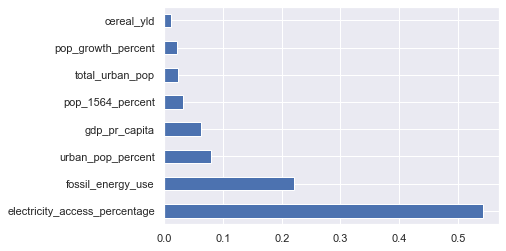

In [43]:
feat_importances = pd.Series(reg_decision_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()


The feature importance chart shows that emissions per capita is largely impacted by electricity_access_percent followed by population numbers and GDP.

# Decision Tree Model Evaluation


In [44]:
# predicting the test set results
prediction=reg_decision_model.predict(X_test)

<AxesSubplot:xlabel='emissions_pr_capita', ylabel='Density'>

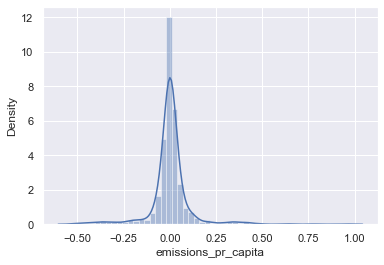

In [45]:
#distribution plot between  label y and predicted y values

sns.distplot(y_test-prediction)

Text(0.5, 1.0, 'True vs. Pred Value for CO2 emissions per capita, DT model')

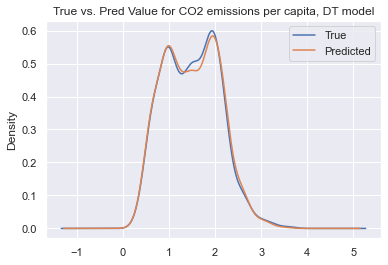

In [46]:
# plot distributions of true and predicted values
y_test.plot.density(label='True')
pd.Series(prediction).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value for CO2 emissions per capita, DT model')

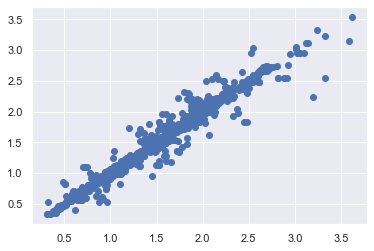

In [47]:
#checking predicted y and labeled y using a scatter plot.
plt.scatter(y_test,prediction)

# Hyper Parameter Tuning using Grid search

The following code demonstartes Hyper parameter tuning to optimize out ML modle. We will use Grid search for our tuning.

In [48]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [49]:
# calculating different regression metrics

from sklearn.model_selection import GridSearchCV
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [50]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [51]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)


In [52]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

#max_depth: or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

#splitter: or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [53]:
# best model score
tuning_model.best_score_

-0.09260867679235658

 # Training Decision Tree With Best Hyperparameters

In [54]:
# applying the best parameters to tune the model
tuned_hyper_model= DecisionTreeRegressor(max_depth=5,max_features='auto',max_leaf_nodes=50,min_samples_leaf=2,min_weight_fraction_leaf=0.1,splitter='random')

In [55]:
# fitting model


tuned_hyper_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=2, min_weight_fraction_leaf=0.1,
                      splitter='random')

In [56]:
# prediction 

tuned_pred=tuned_hyper_model.predict(X_test)

In [78]:
r2 = r2_score(y_test, tuned_pred)
print("R-squared value: ", r2)

R-squared value:  0.6914964568732054


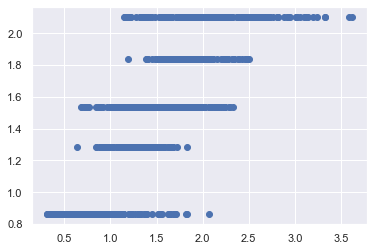

In [57]:
plt.scatter(y_test,tuned_pred)

In [58]:
# # With hyperparameter tuned 
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)))

MAE: 0.2536087887243384
MSE: 0.11113760853177827
RMSE: 0.3333730770949842


In [59]:
# without hyperparameter tuning 
from sklearn import metrics
print('r-2:', metrics.)
print('MAE:', metrics.mean_absolute_error(y_test,prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.05593269124603847
MSE: 0.012268526515505616
RMSE: 0.1107633807515174


# Conclusion on Decision tree Regressor


R-2 96%  is observed without HyperParameter Tuning.
R-2 69% is observed with HyperParameter Tuning


To conclude,the Desicion Tree model is already good at predicting values for emissions_per_capita, there was not much improvement in the model after HyperParameter Tuning.

##  Regressors with Default Hyperparameters

#Using 3-Fold Cross-Validation


In [60]:
clf = RandomForestRegressor()


In [61]:
#Fit train model
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [62]:
#calculate r2 on train and test sets
r1 = clf.score(X_train, y_train)
r2 = clf.score(X_test,y_test)

In [63]:
#rmse and rmse
mse = (mean_squared_error(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [64]:
#print results
print(f'RMSE of Random Forest training set:{(rmse)}')
print(f'MSE of Random Forest training set:{(mse)}')
print(f'R1 of Random Forest training set:{(r1)}')
print(f'R2 of Random Forest training set:{(r2)}')

RMSE of Random Forest training set:0.07954038858038463
MSE of Random Forest training set:0.006326673415518583
R1 of Random Forest training set:0.9969735637921815
R2 of Random Forest training set:0.9824379776506034


# Assess the Goodness-of-Fit

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
In general, the higher the R-squared, the better the model fits your data. 




# Machine learning algorithms used for cross validaton

Random forest (RF), support vector machine (SVM), k-nearest neighbor (KNN)

HPT algorithms used: Grid search, Random search

Performance metric: Mean square error (MSE)

## Random Forest Regression

Random forest is a supervised learning algorithm. It builds a forest with an ensemble of decision trees. It is an easy to use machine learning algorithm that produces a great result most of the time even without hyperparameter tuning.

### Advantages:

    .Can be used for both classificartion and regression tasks
    .Can handle large datasets
    .Higher level of accuracy

### Disadvantages:

    .Can be computationally intensive for large datasets
    .Like a blackbox algorithm. We have very little control over the model

In [65]:
#Random Forest
clf = RandomForestRegressor()
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error') # 3-fold cross-validation
print("MSE:"+ str(-scores.mean()))

MSE:0.053417286609191345


In [66]:
#Support Vector Machine
clf = SVR()
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

MSE:0.13109008461672148


In [67]:
#KNN
clf = KNeighborsRegressor()
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

MSE:0.11648063128178487


# Hyper-Parameter Tuning

## Algorithm 1: Grid SearchCV

Search all the given hyper-parameter configurations

Advantages:
Simple implementation.

Disadvantages:
Time-consuming,
Only efficient with categorical HPs.


In [68]:
#Random Forest

from sklearn.model_selection import GridSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': [100, 580, 930],
    #'max_features': ['sqrt',0.5],
    'max_depth': [180,220,630,750],
    #'min_samples_leaf': [1,2,4,8],
    #"bootstrap":[True,False],
    #"criterion":['mse','mae']
}
clf = RandomForestRegressor(random_state=0)
grid = GridSearchCV(clf, rf_params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X, y)
print(grid.best_params_)
print("MSE:"+ str(-grid.best_score_))

{'max_depth': 180, 'n_estimators': 930}
MSE:0.05274519437279455


# Algorithm 2: Random SearchCV

Randomly search hyper-parameter combinations in the search space

Advantages:
More efficient than GS.
Enable parallelization.

Disadvantages:
Not consider previous results.
Not efficient with conditional HPs.



In [69]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': sp_randint(10,100),
    "max_features":sp_randint(1,13),
    'max_depth': sp_randint(1,50),
    "min_samples_split":sp_randint(2,20),
    "min_samples_leaf":sp_randint(1,11),
    "criterion":['mse','mae']
}
n_iter_search=20 #number of iterations is set to 20, you can increase this number if time permits
clf = RandomForestRegressor(random_state=0)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='neg_mean_squared_error')
Random.fit(X, y)
print(Random.best_params_)
print("MSE:"+ str(-Random.best_score_))


{'criterion': 'mae', 'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 33}
MSE:0.04471743199030682


In [70]:
# Rebuild RandomForest Regressor with best params from Randomized Search CV
rf_best = RandomForestRegressor(n_estimators=140, 
                                max_depth=35,
                                min_samples_split=6, 
                                random_state=42)

#Fit (train) the model
rf_best.fit(X, y)

RandomForestRegressor(max_depth=35, min_samples_split=6, n_estimators=140,
                      random_state=42)

In [71]:
rf_best_prediction = rf_best.predict(X_test)

In [72]:
# Random Forest Regressor metrics
rf_mse = mean_squared_error(y_test, rf_best_prediction)
rf_rmse = mean_squared_error(y_test, rf_best_prediction, squared=False)
rf_r2 = rf_best.score(X_test,y_test)
print(f"Random Forest Regressor MSE: {rf_mse}")
print(f"Random Forest Regressor RMSE: {rf_rmse}")
print(f"Random Forest Regressor R-squared: {rf_r2}")

Random Forest Regressor MSE: 0.0008988642005714997
Random Forest Regressor RMSE: 0.029981064033344444
Random Forest Regressor R-squared: 0.9975048699146082


# Conclusion on Random Forest Regressor

R-squared value of Random forest regressor is 0.98 without hyper parameter tuning
R-squared value of Random forest regressor is 0.99 with hyper parameter tuning

In conclusion, the Random Forest Regressor model with an R-squared value of 0.99 obtained with hyperparameter tuning is a good indication of a good fit and improved performance